In [124]:
'''
Figure 1. Representing methods for this process. 

Things to do:
    Verify lined up
    Verify correct offsets, be robust
'''

'\nFigure 1. Representing methods for this process. \n\nThings to do:\n    Verify lined up\n    Verify correct offsets, be robust\n'

In [125]:
from preprocessing import get_bold_task, task_events
from pupillometry import pupillometry
from persistence import get_dgms, plot_dgms

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec, patches
from matplotlib.ticker import AutoMinorLocator
from matplotlib import collections as mc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.family"] = "Helvetica"

from time import time
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline

from gudhi.wasserstein import wasserstein_distance as qwas

from umap import UMAP
from sklearn.manifold import Isomap, TSNE

import cv2
from PIL import ImageColor

os.chdir('/Users/spencerbrown/PycharmProjects/Neuro')

cmap = [
    '#003f5c',
    '#2f4b7c',
    '#665191',
    '#a05195',
    '#d45087',
    '#f95d6a',
    '#ff7c43',
    '#ffa600']

In [126]:
atlas = 'Schaefer2018_fslr32k'
task = 'MOTOR'
# parcels = [200, 300, 400]
parcels = 300
dims = 2 # Number of homology dimensions to compute.
frames = 284
TR = 0.72
acquisition = frames * TR

bw = 15 # std of gaussian kernel.

subject = 100610

In [127]:
def kern_a(std, offset):
    t = np.arange(frames) + 0.5 # offsets to look at center of frame
    sig2 = 2 * std * std
    w = np.exp(-1 * ((t - offset) ** 2) / sig2)
    w[int(offset):] = 0
    scale = 2 / (std*np.sqrt(2*np.pi))
    w = w * scale
    return w

def kern_b(std, offset):
    t = np.arange(frames) + 0.5
    sig2 = 2 * std * std
    w = np.exp(-1 * ((t - offset) ** 2) / sig2)
    w[:int(offset)] = 0
    scale = 2 / (std*np.sqrt(2*np.pi))
    w = w * scale
    return w

# plt.figure(figsize=(6, 2))
# plt.plot(t, kern_a(std=20, offset=100.5), alpha=0.5, c=cmap[0])
# plt.plot(t, kern_b(std=20, offset=100.5), alpha=0.5, c=cmap[3])
# plt.axvline(100.5, c='k', linestyle='--')

In [128]:
t0 = time()
sub = subject # subject to consider
run = 0

bold = get_bold_task(sub, run, atlas, parcels, task)

t_frames = np.arange(2*bw, frames - 2*bw + 1)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [129]:
adjs_a = []
adjs_b = []
L2 = []
for w in t_frames:
    ka = kern_a(bw, w)
    kb = kern_b(bw, w)

    bold_a = bold * ka
    adj_a = 1 - np.corrcoef(bold_a)

    bold_b = bold * kb
    adj_b = 1 - np.corrcoef(bold_b)
    
    adjs_a.append(adj_a)
    adjs_b.append(adj_b)
    L2.append(np.linalg.norm((adj_b - adj_a), ord='fro'))


adjs_a = np.stack(adjs_a, axis=0)
adjs_b = np.stack(adjs_b, axis=0)
L2 = np.array(L2)

print(f'Completed subject {sub} run {run}, Time elapsed: {time()-t0}')

Completed subject 100610 run 0, Time elapsed: 3.4140851497650146


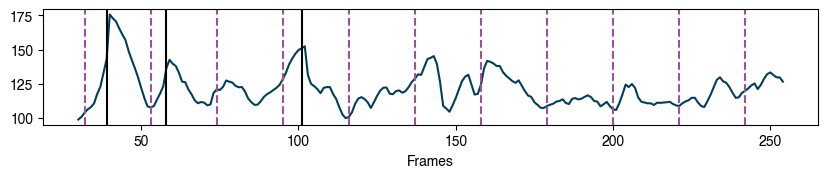

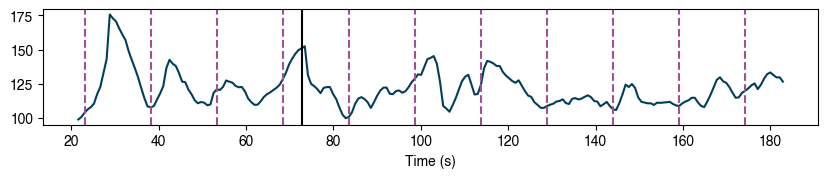

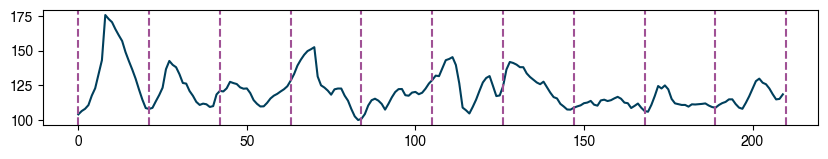

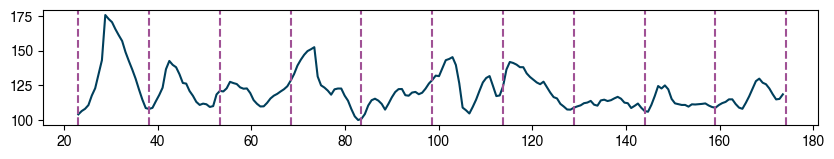

In [130]:
cues = np.arange(11, 263+21, 21) # In frame space.
cues_frame = cues[1:-1] # dropping first and last.
cues_time = cues_frame * TR # converted to a time space. 
cues_offset = cues_frame - cues_frame[0]

t_time = t_frames * TR

start_drop = np.ceil(cues_frame[0] - t_frames[0]).astype(int)
acquisition_valid = (len(cues_frame) - 1) * 21

t_offset = np.arange(acquisition_valid)
L2_new = L2[start_drop:start_drop + acquisition_valid]


''' Plotting in a frame domain '''
plt.figure(figsize=(10, 1.5))
plt.plot(t_frames, L2, c=cmap[0])
plt.xlabel('Frames')

plt.axvline(t_frames[9], c='k')
plt.axvline(t_frames[28], c='k')
plt.axvline(t_frames[71], c='k')

for i in cues_frame:
    plt.axvline(i, c=cmap[3], linestyle='--')
plt.show()


''' Plotting in a time domain '''
plt.figure(figsize=(10, 1.5))
plt.plot(t_time, L2, c=cmap[0])
plt.xlabel('Time (s)')
for i in cues_time:
    plt.axvline(i, c=cmap[3], linestyle='--')

plt.axvline((71+t_frames[0])*TR, c='k')
plt.show()

''' Frame offset by cue_0 domain '''
plt.figure(figsize=(10, 1.5))
plt.plot(t_offset, L2_new, c=cmap[0])
for i in cues_offset:
    plt.axvline(i, c=cmap[3], linestyle='--')
plt.show()

plt.figure(figsize=(10, 1.5))
plt.plot(t_offset*TR + cues_time[0], L2_new, c=cmap[0])
for i in cues_time:
    plt.axvline(i, c=cmap[3], linestyle='--')
plt.show()

# Note - reconsitute event type?

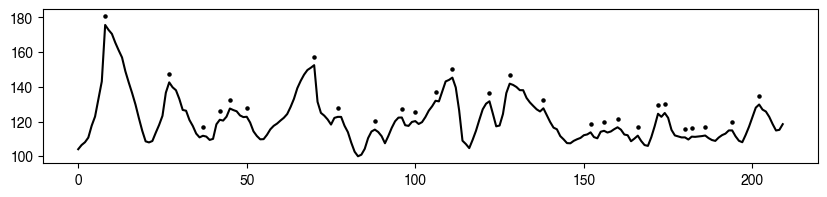

In [131]:
'''
Buffer on top/bottom: around 10. Put dot around 5 above.
Use scatterplot, black, solid.

'''

peaks, properties = find_peaks(L2_new, prominence=-999, height=-999)
heights = properties['peak_heights']
proms = properties['prominences']

plt.figure(figsize=(10, 2))
plt.plot(L2_new, c='k')
# for i in peaks:
#     plt.axvline(i, c='r', linestyle='--')
plt.scatter(peaks, heights + 5, c='k', s=5)

plt.show()

In [132]:
print(cues_time)
print(k_time)

[ 23.04  38.16  53.28  68.4   83.52  98.64 113.76 128.88 144.   159.12
 174.24]
73.44


In [133]:
'''
Visualizing states at a transition point
'''

k_frame = 72 # frame of interest for transition.
k_abs = 72 + t_frames[0]
k_time = (k_abs)*TR


info_path = f'./Atlases/{atlas}/Schaefer2018_{parcels}Parcels_7Networks_order_info.txt'
networks_raw = np.array(pd.read_csv(info_path, sep='\t', header=None)).flatten()[::2]
networks = [i.split('_')[2] for i in networks_raw]
networks = np.array(networks)

new_ind = np.argsort(networks, kind='stable')
networks = networks[new_ind]

network_labels = np.unique(networks)
network_ticks = [np.min(np.where(networks == i)) for i in np.unique(networks)]
network_ticks = np.array(network_ticks)
network_ticks = np.append(network_ticks, parcels-1)

# k = 71 # Transition point of interest. Corresponds to cue point #3 from HCP
adj_1 = adjs_a[k_frame, ...]
adj_1 = adj_1[new_ind, :]
adj_1 = adj_1[:, new_ind]

adj_2 = adjs_b[k_frame, ...]
adj_2 = adj_2[new_ind, :]
adj_2 = adj_2[:, new_ind]

# embed_1 = UMAP(n_components=2, random_state=2025).fit_transform(adj_1)
# embed_2 = UMAP(n_components=2, random_state=2025).fit_transform(adj_2)  

In [134]:
col = ImageColor.getcolor(cmap[0], "RGB")
col = np.array(col)
alpha = 1.0
col_L = (alpha*col + (1-alpha)*np.array((255, 255, 255))).astype('uint8')
col_L = '#{:02x}{:02x}{:02x}'.format(col_L[0], col_L[1], col_L[2])
alpha = 0.8
col_R = (alpha*col + (1-alpha)*np.array((255, 255, 255))).astype('uint8')
col_R = '#{:02x}{:02x}{:02x}'.format(col_R[0], col_R[1], col_R[2])


''' Util functions '''
def add_networks(axis):
    axis.tick_params(axis='both', top=False, bottom=True)
    axis.set_xticks(network_ticks, labels=[])
    axis.set_yticks(network_ticks, labels=[])
    
    for i in network_ticks[1:-1]:
        axis.axvline(i, c='w', linewidth=1, alpha=0.8)
        axis.axhline(i, c='w', linewidth=1, alpha=0.8)
    
    for i in range(len(network_labels)):
        m = (network_ticks[i] + network_ticks[i+1]) / 2 # middle of the ticks
        m = m + 2
        axis.text(-8, m, network_labels[i], fontsize=10,
                 horizontalalignment='right', verticalalignment='center')
        axis.text(m, 300+8, network_labels[i], fontsize=10, rotation=90,
                 horizontalalignment='center', verticalalignment='top')

def annotate():
    '''
    Figure annotations
    '''
    fac=3

    # "Correlations" annotation - seems unecessary?
    # y0 = 385*fac
    # corner = (915*fac, y0)
    # length = 155*fac
    # width = 40*fac
    # path = [
    #     [corner[0], corner[1]],
    #     [corner[0]-width/2, corner[1]+width/2],
    #     [corner[0], corner[1]+width],
    #     [corner[0]+length, corner[1]+width],
    #     [corner[0]+length, corner[1]]
    # ]
    # fig.patches.append(patches.Polygon(path, linewidth=0, edgecolor=cmap[0], facecolor=cmap[0]))
    # coords = fig.transFigure.inverted().transform((corner[0]+22*fac, corner[1]+53*fac))
    # fig.text(x=coords[0], y=coords[1], s='Correlations', ha='left', va='center', c='white', fontsize=16)

    ''' Drawing Left and Right states '''
    #y0 = 515*fac
    y0 = 540*fac
    # Distance annotation?
    corner = (141*fac, y0)
    length = 197*fac
    width = 40*fac
    path = [
        [corner[0], corner[1]],
        [corner[0], corner[1]+width],
        [corner[0]+length, corner[1]+width],
        [corner[0]+length, corner[1]]
    ]
    fig.patches.append(patches.Polygon(path, linewidth=0, edgecolor=cmap[0], facecolor=cmap[0]))
    coords = fig.transFigure.inverted().transform((corner[0]+108*fac, corner[1]+53*fac))
    fig.text(x=coords[0], y=coords[1], s='Left State', ha='center', va='center', c='white', fontsize=16)
    corner = (618*fac, y0)
    length = 197*fac
    width = 40*fac
    path = [
        [corner[0], corner[1]],
        [corner[0], corner[1]+width],
        [corner[0]+length, corner[1]+width],
        [corner[0]+length, corner[1]]
    ]
    fig.patches.append(patches.Polygon(path, linewidth=0, edgecolor=cmap[0], facecolor=cmap[0]))
    coords = fig.transFigure.inverted().transform((corner[0]+108*fac, corner[1]+53*fac))
    fig.text(x=coords[0], y=coords[1], s='Right State', ha='center', va='center', c='white', fontsize=16)
    
    ''' Drawing converging arrow '''
    # Long arrow:
    # Parameters for long arrow
    x1 = 474*fac
    x1_offset = x1 + 6*fac
    x3 = 512*fac
    
    y0 = 235*fac
    y1 = y0 + 25*fac
    y3 = y1 + 80*fac
    #y4 = 235*fac
    y4 = 275*fac
    
    rect = patches.Rectangle((x1-6*fac-38*fac, y3), 12*fac, y4, linewidth=0, edgecolor=col_L, facecolor=col_L)
    fig.patches.append(rect)
    
    rect = patches.Rectangle((x1-6*fac+38*fac, y3), 12*fac, y4, linewidth=0, edgecolor=col_R, facecolor=col_R)
    fig.patches.append(rect)
    
    x = [x1_offset, (x1_offset+x3)/2, x3]
    y = [y1, (y1+y3)/2, y3]
    cs = CubicSpline(y, x, bc_type=((1, 0), (1, 0)))
    
    y_smooth = np.linspace(y1, y3, 100*fac)
    x_smooth = cs(y_smooth)
    
    x_smooth = np.concatenate([x_smooth - 6*fac, x_smooth[::-1] + 6*fac])
    y_smooth = np.concatenate([y_smooth+3*fac, y_smooth[::-1]])
    path = [(x_smooth[i], y_smooth[i]) for i in range(len(x_smooth))]
    fig.patches.append(patches.Polygon(path, linewidth=0, edgecolor=col_R, facecolor=col_R))
    
    x_smooth = -1 * x_smooth + 2*x1
    path = [(x_smooth[i], y_smooth[i]) for i in range(len(x_smooth))]
    fig.patches.append(patches.Polygon(path, linewidth=0, edgecolor=col_L, facecolor=col_L))
    
    # End arrow
    corner = (x1-12.5*fac, y0)
    length=35*fac
    # path = [
    #     [corner[0], corner[1]],
    #     [corner[0]+12*fac, corner[1]-12.5*fac],
    #     [corner[0]+25*fac, corner[1]],
    #     [corner[0]+25*fac, corner[1]+length],
    #     [corner[0], corner[1]+length]
    # ]
    # fig.patches.append(patches.Polygon(path, linewidth=0, edgecolor=col_L, facecolor=col_L))
    # coords = fig.transFigure.inverted().transform((corner[0]-4*fac, corner[1]+94*fac))

    path = [
        [corner[0], corner[1]],
        [corner[0]+12.5*fac, corner[1]-12.5*fac],
        [corner[0]+12.5*fac, corner[1]+length],
        [corner[0], corner[1]+length]
    ]
    fig.patches.append(patches.Polygon(path, linewidth=0, edgecolor=col_L, facecolor=col_L))
    path = [
        [corner[0]+25*fac, corner[1]],
        [corner[0]+12.5*fac, corner[1]-12.5*fac],
        [corner[0]+12.5*fac, corner[1]+length],
        [corner[0]+25*fac, corner[1]+length]
    ]
    fig.patches.append(patches.Polygon(path, linewidth=0, edgecolor=col_R, facecolor=col_R))
    
    # Counter label:
    corner = (x1-12.5*fac, 55*fac)
    path = [
        [corner[0], corner[1]],
        [corner[0]+12.5*fac, corner[1]+12.5*fac],
        [corner[0]+25*fac, corner[1]],
        [corner[0]+25*fac, corner[1]-10*fac],
        [corner[0], corner[1]-10*fac]
    ]
    fig.patches.append(patches.Polygon(path, linewidth=0, edgecolor=col_L, facecolor=col_L))

    # # Slide-rule type connection:
    # path = [[x1, 55*fac], [x1, y0]]
    # line = patches.Polygon(path, closed=False, edgecolor=col_L, linewidth=4, facecolor='none', alpha=0.5)
    # fig.patches.append(line)
    
    
    # x1 = 937*fac
    # corner = (x1-12.5*fac, 55*fac)
    # path = [
    #     [corner[0], corner[1]],
    #     [corner[0]+12.5*fac, corner[1]+12.5*fac],
    #     [corner[0]+25*fac, corner[1]],
    #     [corner[0]+25*fac, corner[1]-10*fac],
    #     [corner[0], corner[1]-10*fac]
    # ]
    # fig.patches.append(patches.Polygon(path, linewidth=0, edgecolor=cmap[0], facecolor=cmap[0]))
    #
    # width = 100
    # corner = (x1-12.5*fac, 235*fac)
    # path = [
    #     [corner[0], corner[1]],
    #     [corner[0]+12.5*fac, corner[1]-12.5*fac],
    #     [corner[0]+25*fac, corner[1]],
    #     [corner[0]+25*fac, corner[1]+width*fac],
    #     [corner[0], corner[1]+width*fac],
    # ]
    # fig.patches.append(patches.Polygon(path, linewidth=0, edgecolor=cmap[0], facecolor=cmap[0]))
    # coords = fig.transFigure.inverted().transform((corner[0]+22*fac, corner[1]+83*fac))
    # fig.text(x=coords[0], y=coords[1], s='Task cues', ha='center', va='center', c='white', rotation=90, fontsize=12)

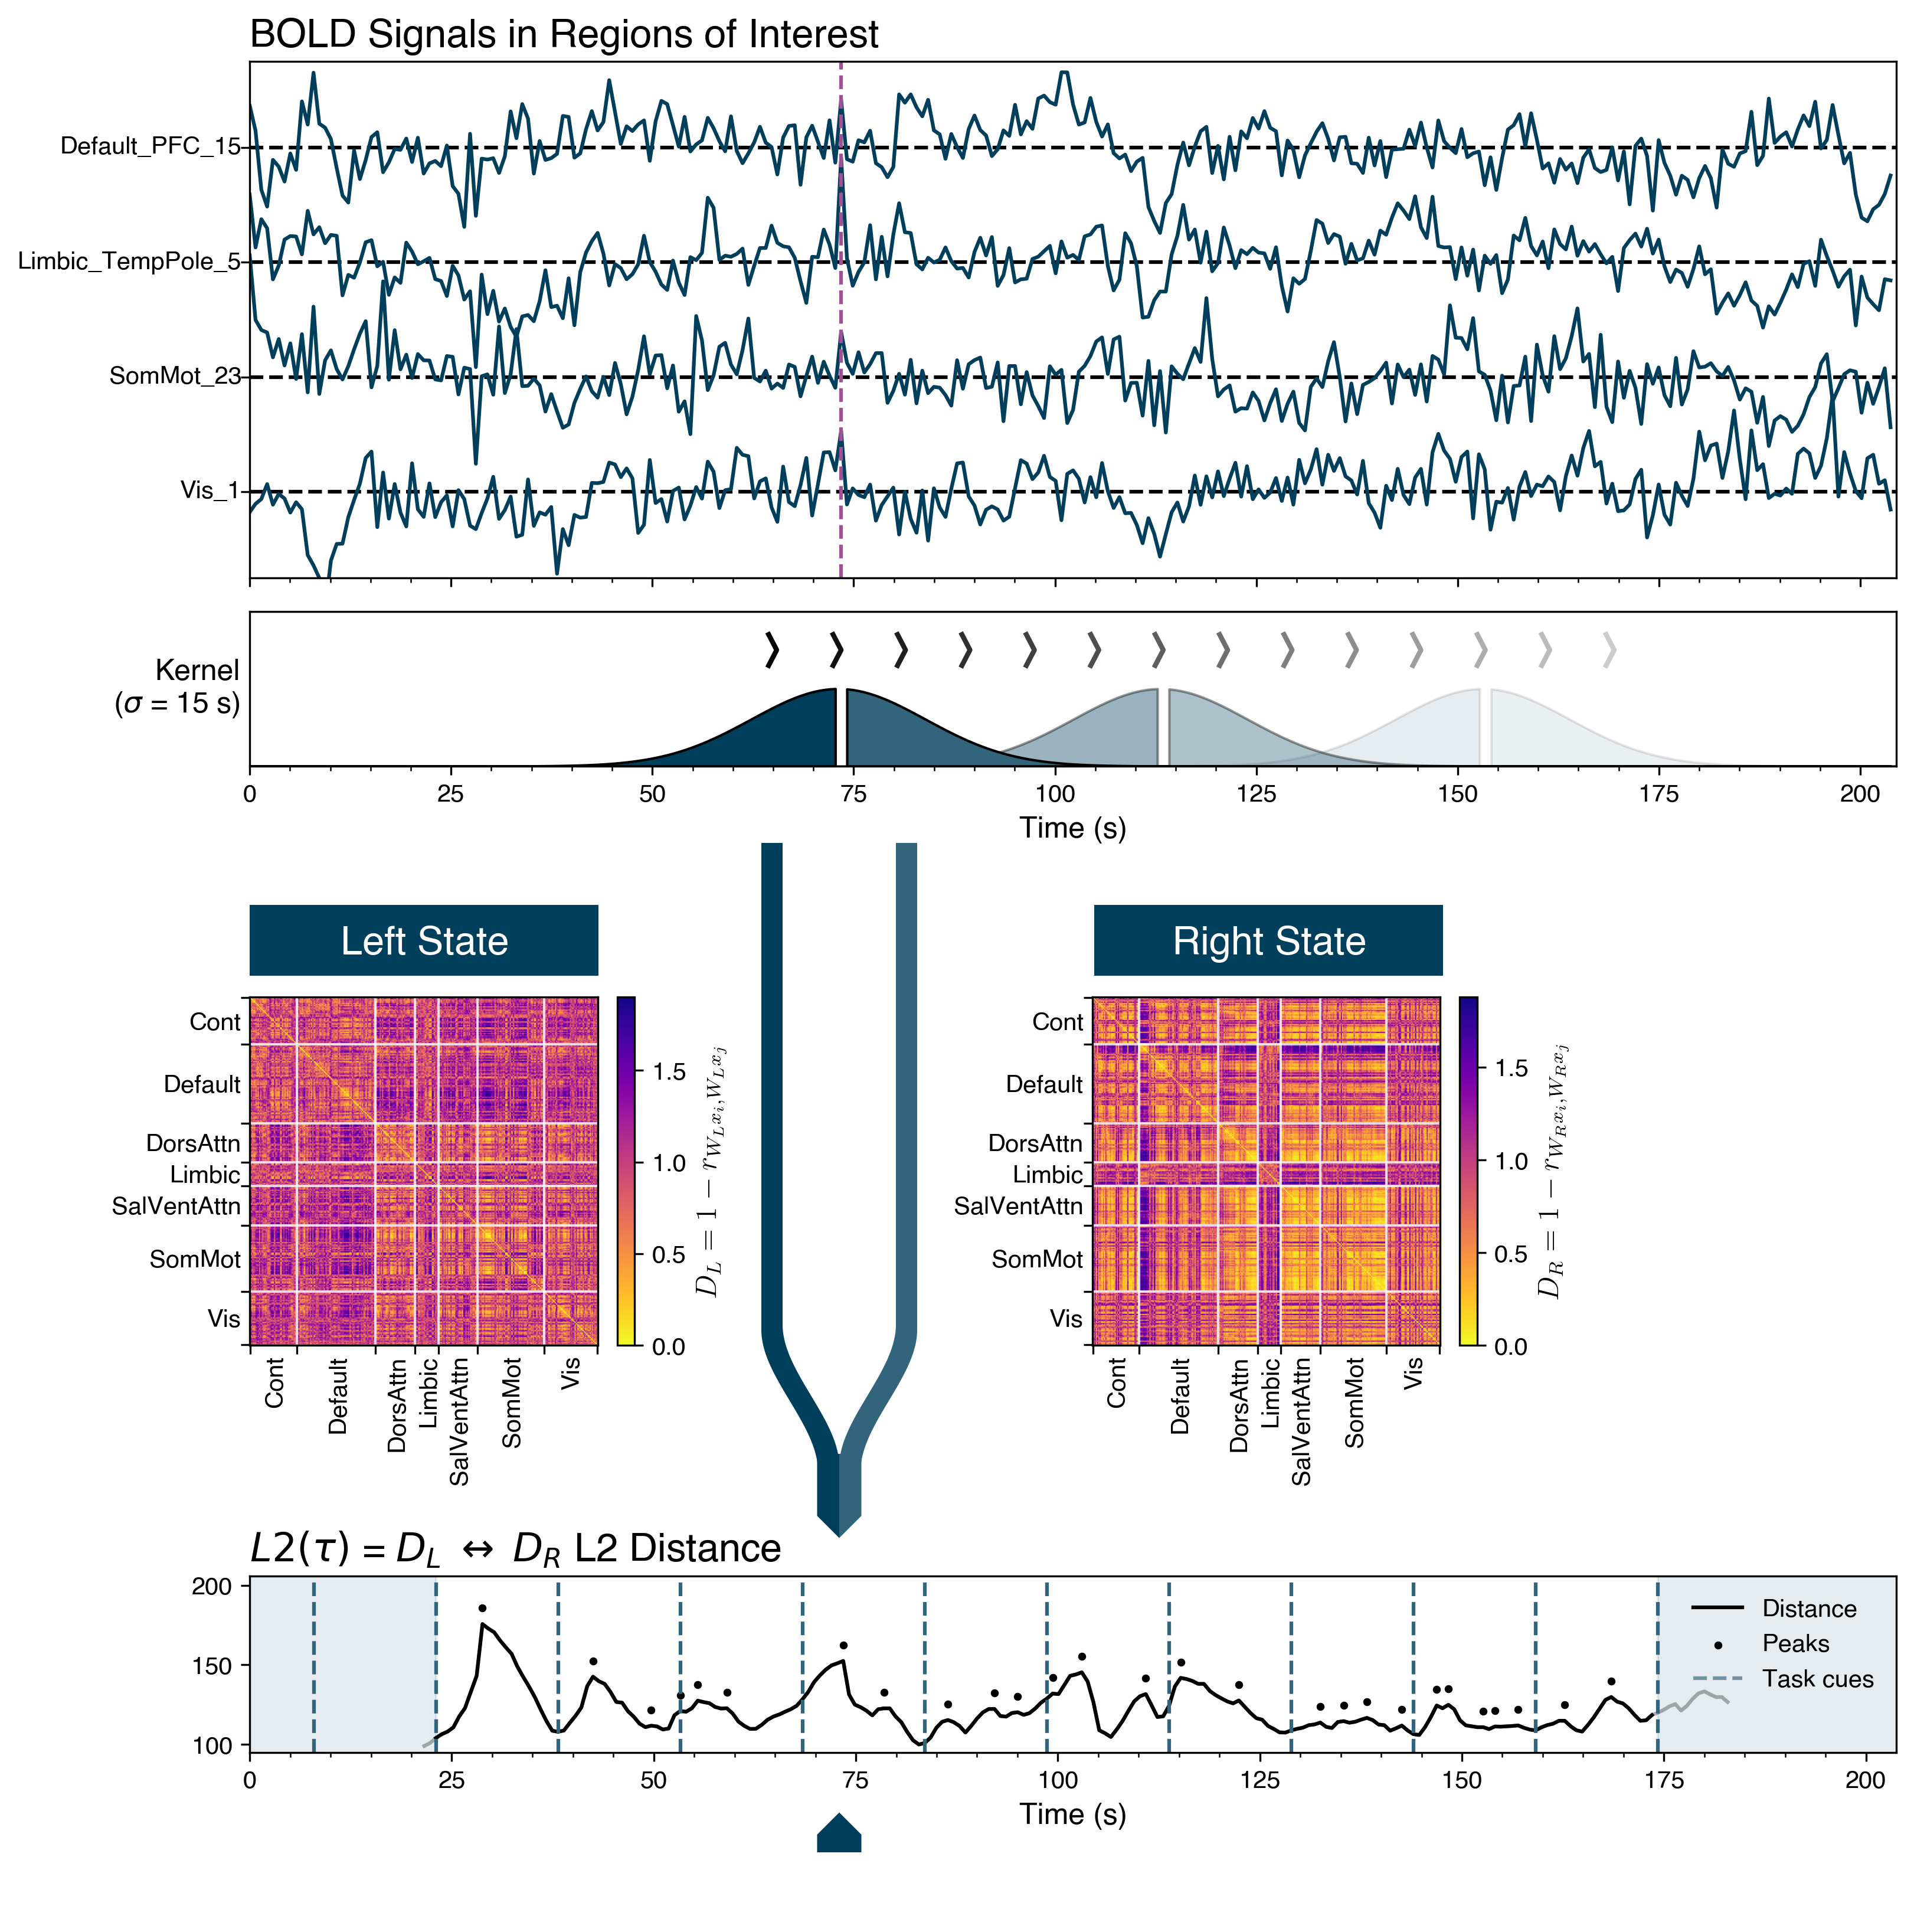

In [155]:
''' Global figure '''
fig = plt.figure(figsize=(12, 12.4), dpi=300)
gs_global = gridspec.GridSpec(3, 1, height_ratios=[6, 4.5, 1.5], hspace=0.3)

''' Original singal z-scored '''
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_global[0], height_ratios=[1, 0.3], wspace=0.1, hspace=0.1)

ax = fig.add_subplot(gs1[0])
t = np.arange(bold.shape[1])*TR

ax.axhline(0, linestyle='--', c='k')
ax.axhline(4, linestyle='--', c='k')
ax.axhline(8, linestyle='--', c='k')
ax.axhline(12, linestyle='--', c='k')

fac = 46
for i in range(4):
    ax.plot(t, bold[fac*i, :] + 4*i, c=cmap[0], alpha=1)
    ax.text(-1, 4*i, networks_raw[fac*i][13:], horizontalalignment='right', verticalalignment='center')

ax.set_xlim(0, frames*TR)
ax.set_ylim(-3, 15)
ax.tick_params(labelleft=False, labelbottom=False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_yticks(np.arange(0, 15, 4))

ax.axvline(k_time, linestyle='--', c=cmap[3])

ax.set_title('BOLD Signals in Regions of Interest', fontsize=16, loc='left')


ax = fig.add_subplot(gs1[1])
''' Kernel display '''
ka = kern_a(bw, k_abs)
kb = kern_b(bw, k_abs)

# Normalizing ka/b to make arrows easier:
ka = ka / np.max(ka) * 0.5
kb = kb / np.max(kb) * 0.5

def draw_kernel(offset, alpha):
    ax.fill_between(t[:int(k_abs)] + offset, ka[:int(k_abs)], 0, color=col_L, edgecolor='k', alpha=alpha)
    ax.fill_between(t[int(k_abs+1):] + offset, kb[int(k_abs+1):], 0, color=col_R, edgecolor='k', alpha=alpha)
    return None

draw_kernel(80, 0.1)
draw_kernel(40, 0.4)
draw_kernel(0, 1)


ax.set_xlim(0, frames * TR)
ax.set_ylim(0, 1.0)
ax.tick_params(labelleft=False)
ax.set_xticks(np.linspace(0, 200, 9))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_yticks([])
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Kernel\n' r'($\sigma$ = 15 s)', rotation=0, ha='right', va='center', fontsize=12)

# Fading arrows to show movement of the kernel:
space = 8
x = np.arange(k_time-9, k_time+110, 1)
y = 0.75
w = 0.10
width = 2
cols = [(0, 0, 0, alpha) for alpha in np.linspace(1, 0.2, len(x)//space)]
ind = 0
for i in space * np.arange((len(x))//space):
    ax.plot([x[i], x[i+1], x[i]], [y-w, y, y+w], c=cols[ind], linewidth=width)
    ind += 1

''' 
Divergence to substates 
'''
gs_subnet = gridspec.GridSpecFromSubplotSpec(1, 4, 
                                             hspace=0.4, wspace=0.1, width_ratios=[1, 1.2, 1, 1.2],
                                             subplot_spec=gs_global[1])

''' Plotting distance/adjacency matrix '''
# Substate L adjacency matrix:
ax = fig.add_subplot(gs_subnet[0, 0])
img = ax.imshow(adj_1, cmap='plasma_r')
add_networks(ax)

cax = inset_axes(ax, width="5%", height="100%", loc='right', borderpad=-1.5)
cbar = fig.colorbar(img, cax=cax)
#cbar.set_label(f'1 - $r$', fontsize=12, fontweight='bold')
cbar.set_label(r'$D_L = 1 - r_{W_{L} x_{i}, W_{L} x_{j}}$', fontsize=12, usetex=True)

# Substate R adjacency matrix:
ax = fig.add_subplot(gs_subnet[0, 2])
img = ax.imshow(adj_2, cmap='plasma_r')
add_networks(ax)

cax = inset_axes(ax, width="5%", height="100%", loc='right', borderpad=-1.5)
cbar = fig.colorbar(img, cax=cax)
# cbar.set_label(f'1 - $r$', fontsize=12, fontweight='bold')
cbar.set_label(r'$D_R = 1 - r_{W_{R} x_{i}, W_{R} x_{j}}$', fontsize=12, usetex=True)


''' Convergence. '''
gs3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_global[2], wspace=0.1, hspace=0.1)

ax = fig.add_subplot(gs3[0])
#ax.plot(t_time, L2, c=cmap[0])
ax.plot(t_time, L2, c='k', alpha=0.3)
ax.plot(t_offset*TR + cues_time[0], L2_new, c='k', label='Distance')


peaks, properties = find_peaks(L2_new, prominence=-999, height=-999)
peaks = peaks*TR + cues_time[0]
heights = properties['peak_heights']
ax.scatter(peaks, heights + 10, c='k', s=5, label='Peaks')

# ax.axvline(k_time, linestyle='--', c=cmap[0])
# ax.set_ylabel('L \u2194 R\nDistance', rotation=0, ha='right', va='center', fontsize=12)
# ax.set_ylabel(r'L  $\leftrightarrow$  R '
#               '\n Distance', rotation=0, ha='right', va='center', fontsize=12)
ax.set_xlim(0, t[-1])
ax.set_ylim(np.min(L2_new)-5, np.max(L2_new)+30)
ax.set_xticks(np.linspace(0, 200, 9))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.axvspan(0, cues_time[0], color=cmap[0], alpha=0.1)
ax.axvspan(cues_time[-1], frames*TR, color=cmap[0], alpha=0.1)
for i in cues[:-1]*TR:
    ax.axvline(i, linestyle='--', c=col_R)
ax.axvline(-999, linestyle='--', c=cmap[0], alpha=0.5, label='Task cues')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_title(r'$L2(\tau)$ = $D_L$ $\leftrightarrow$ $D_R$ L2 Distance', fontsize=16, loc='left')

# rect = patches.Rectangle((-999, -10), 1, 1,
#                  facecolor='white', edgecolor='black', label='Period of analysis')
# ax.add_patch(rect)
# rect = patches.Rectangle((-999, -10), 1, 1,
#                  facecolor=cmap[0], edgecolor='black', alpha=0.1, label='Period of analysis')
# ax.add_patch(rect)

legend = ax.legend(loc='upper right', fontsize=10, frameon=False)

annotate()
fig.savefig('Figure 1', dpi=300, bbox_inches='tight')
plt.show()

In [136]:
'''
Todo: figure should have more detailed descriptsion. Representing phase transition notable at cue point.
    Can describe - BOLD signal on top, pairwise kernel ->
    Fix start/end by 1 sec...

Next figures I need to maek:
    One fig - notably with both the impulse response function?? And the cue time, etc.
Note - consider the task cues - in absolute and if can do an additional cue, would be a simple addition here.
Can also just list the 7 networks earlier, and just use this here.

Todo tomorrow - validate cue time points, offset time points = get optimal offset.
TODO: draw light "shadow" for invalid parts. Describe.

NOTE - need to have good definitions early on.
'''

'\nTodo: figure should have more detailed descriptsion. Representing phase transition notable at cue point.\n    Can describe - BOLD signal on top, pairwise kernel ->\n    Fix start/end by 1 sec...\n\nNext figures I need to maek:\n    One fig - notably with both the impulse response function?? And the cue time, etc.\nNote - consider the task cues - in absolute and if can do an additional cue, would be a simple addition here.\nCan also just list the 7 networks earlier, and just use this here.\n\nTodo tomorrow - validate cue time points, offset time points = get optimal offset.\nTODO: draw light "shadow" for invalid parts. Describe.\n\nNOTE - need to have good definitions early on.\n'

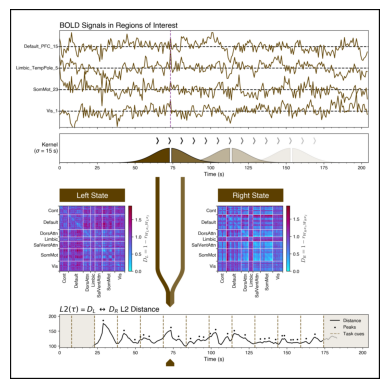

In [156]:
fig = cv2.imread('Figure 1.png')

pad_R = 75
pad_U = 90
pad_L = 25

fig = np.concatenate([fig, 255 * np.ones((fig.shape[0], pad_R, 3))], axis=1)
fig = np.concatenate([255 * np.ones((fig.shape[0], pad_L, 3)), fig], axis=1)
fig = np.concatenate([255 * np.ones((pad_U, fig.shape[1], 3)), fig], axis=0)

fig = fig[:-20, :, :]
fig[:10, :, :] = 0
fig[:, :10, :] = 0
fig[-10:, :, :] = 0
fig[:, -10:, :] = 0

fig = fig.astype(np.uint8)
cv2.imwrite('Figure 1_ammended.png', fig)

plt.imshow(fig)
plt.axis('off')
plt.show()

In [138]:
'''
Next steps: 04/08/25:
    use z=2 as cutoff for prominences <- OR 95%.
    Dislpay those peaks <- use a 'dot' - add legend for these!
    Display other parts as '--'

Valid region of L2: L2_new ~ [t_offset*TR + cues_time[0]]
Full region: L2 ~ t_time, L2 <- use '--' for this


Protocol for finding peaks:
    1. Lookg at every peak = raw -> pull prominences
    2. Build distribution of those.


Adjustments:
    Remove "task cues" label - move to legend
    Put "compute L2 between these" as new thing by arrow.
    Change "L2 distance" -> "Distance"

L2 legend:
    L2 distance
    Peaks - as dot
    Task cue"
    "invalid time points" - as gray box
'''

'''
Further tasks/ideas:
Need a few eequations as a basis.
'''

'\nFurther tasks/ideas:\nNeed a few eequations as a basis.\n'

In [139]:
fig.shape

(3343, 3343, 3)